# First-Level GLM Analysis

In [178]:
import pickle
from pathlib import Path
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn.datasets import load_mni152_brain_mask
from nistats.design_matrix import make_first_level_design_matrix
from nistats.first_level_model import FirstLevelModel
from nistats.reporting import plot_design_matrix

## 1. In-depth single subject walkthrough

### 1.1. Setting up the data

In [96]:
# get file path and then load NIfTI into Python
func_file = Path(f'data/derivatives/fmriprep/sub-01/ses-test/func/'
                 f'sub-01_ses-test_task-fingerfootlips_space-'
                 'MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
func_img = nib.load(func_file)

Next, we will also need the run's motion parameters that were extracted during motion correction in preprocessing. fmriprep stores all of the parameters, along with many others, in the `confounds_regressors.tsv` files. Each run has one of these files. 

We will use Pandas to load in the file into python, and then select only the motion parameters. 

In [159]:
conf_file = Path(f'data/derivatives/fmriprep/sub-01/ses-test/func/'
                 f'sub-01_ses-test_task-fingerfootlips_desc-confounds_regressors.tsv')

# load into Python
conf_df = pd.read_table(conf_file)

# give a list of column names to index; only these will be kept
columns = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
motion_params = conf_df[columns]
motion_params

,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
0,-6.811590e-03,0.000000,0.000000,0.000000,-0.000000,0.000000
1,0.000000e+00,-0.032630,0.379690,0.001518,-0.000000,0.000000
2,-3.186770e-09,-0.024637,0.412426,0.001210,-0.000000,0.000000
3,0.000000e+00,-0.032607,0.409083,0.001864,-0.000000,0.000000
4,-7.909900e-10,-0.039145,0.424855,0.001828,-0.000000,0.000000
...,...,...,...,...,...,...
179,-5.842920e-01,0.271957,1.750190,0.000408,0.003392,-0.013274
180,-6.223520e-01,0.225294,1.784710,0.000221,0.003651,-0.013307
181,-6.690440e-01,0.212441,1.818840,-0.000384,0.003936,-0.013668
182,-6.945650e-01,0.231569,1.832250,-0.000719,0.004015,-0.013972


### 1.2. Defining the model

Before we set up a model, let's load in a brain mask of the MNI template. This mask will restrict analysis to voxels only inside the brain. We can do this using nilearn's `load_mni152_brain_mask` function that we imported at the start of the notebook. This mask is in 2mm isovoxel space, but this will get resampled to the resolution of the functional files that we are using (4mm isovoxel). 

In [123]:
brain_mask = load_mni152_brain_mask()

Next, we will specify our model. Nistats makes it really easy to specify a GLM. The `FirstLevelModel` class let's you define all your parameters in one step, and then you can use it's methods to fit the model and define contrasts. Lastly, because it is a class, it has attributes that you can access. Notably, you can view the design matrix of the model, which is _somehting that you should always be doing_. 

The [online documentation](https://nistats.github.io/modules/generated/nistats.first_level_model.FirstLevelModel.html#nistats.first_level_model.FirstLevelModel) for the `FirstLevelModel` gives a description for each parameter. For our analysis, a few things are required:
- The TR, which is 2.5s
- The HRF model, in which there are several to choose from (see documentation for the options). We will choose Glover's (1999) canonical HRF along with the temporal derivative. Adding the derivative is often recommended to improve model fit. The option we'll use is 'glover + derivative'. 
- We also want to apply some additional processing steps, on top of what was done with fmriprep. We will scale and temporally filter the data (0.01Hz), and spatially smooth the data using a 6mm FWHM kernel. 

Some of the above options are the default parameters, but we'll explicitly specify them.

In [134]:
model = FirstLevelModel(t_r=2.5, hrf_model='glover + derivative', high_pass=.01, 
                        signal_scaling=False, standardize=True, smoothing_fwhm=6, 
                        mask_img=brain_mask, verbose=1)
model

FirstLevelModel(drift_model='cosine', drift_order=1, fir_delays=[0],
                high_pass=0.01, hrf_model='glover + derivative',
                mask_img=<nibabel.nifti1.Nifti1Image object at 0x7ff7dcc2ccf8>,
                memory=Memory(location=None), memory_level=1, min_onset=-24,
                minimize_memory=True, n_jobs=1, noise_model='ar1',
                signal_scaling=False, slice_time_ref=0.0, smoothing_fwhm=6,
                standardize=True, subject_label=None, t_r=2.5,
                target_affine=None, target_shape=None, verbose=1)

### 1.3 The model design

In nistats, there are a few different ways to build a design matrix. You can build one directly using the `make_first_level_design_matrix` function from the `design_matrix` module (see [documentation](https://nistats.github.io/modules/generated/nistats.design_matrix.make_first_level_design_matrix.html#nistats.design_matrix.make_first_level_design_matrix)). I'd recommend trying this in your own time because it's nice to build your design matrix and inspect it before running your analysis.

For this lesson, we'll use the much simpler way of specifying a design matrix: we will by pass in an events file when fitting the model. The downside to this approach is that we can only inspect our design matrix _after_ the model has finished fitting.

Let's load in that events file that tells us each trial/block's onset, duration, and condition. We'll load this in using pandas' `read_table` function. 

In [135]:
event_file = Path('data/task-fingerfootlips_events.tsv')
events = pd.read_table(event_file)
events

,onset,duration,weight,trial_type
0,10,15.0,1,Finger
1,40,15.0,1,Foot
2,70,15.0,1,Lips
3,100,15.0,1,Finger
4,130,15.0,1,Foot
5,160,15.0,1,Lips
6,190,15.0,1,Finger
7,220,15.0,1,Foot
8,250,15.0,1,Lips
9,280,15.0,1,Finger


We see that this is a block design (15s each) and that there are 15 blocks (5 each condition). When we pass this DataFrame into our model, it will be transformed to a proper design matrix. 

### 1.4 Fitting the model

We fit the model by calling the `.fit()` method. In this method, we pass in the functional image, our events data, and the motion parameters that we saved earlier. 

In [136]:
model.fit(func_img, events=events, confounds=motion_params)

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 38 seconds



FirstLevelModel(drift_model='cosine', drift_order=1, fir_delays=[0],
                high_pass=0.01, hrf_model='glover + derivative',
                mask_img=<nibabel.nifti1.Nifti1Image object at 0x7ff7dcc2ccf8>,
                memory=Memory(location=None), memory_level=1, min_onset=-24,
                minimize_memory=True, n_jobs=1, noise_model='ar1',
                signal_scaling=False, slice_time_ref=0.0, smoothing_fwhm=6,
                standardize=True, subject_label=None, t_r=2.5,
                target_affine=None, target_shape=None, verbose=1)

Now that we've run our model, we can inspect the design matrix. As emphasized earlier, it's really important to check your design matrix to ensure that it is correct. Small errors, which can easily be spotted by looking at the design matrix in the design, can have large effects on your results.

In [137]:
design = model.design_matrices_[0]
design

,Finger,Finger_derivative,Foot,Foot_derivative,Lips,Lips_derivative,trans_x,trans_y,trans_z,rot_x,...,drift_1,drift_2,drift_3,drift_4,drift_5,drift_6,drift_7,drift_8,drift_9,constant
0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-6.811590e-03,0.000000,0.000000,0.000000,...,0.104253,0.104242,0.104223,0.104196,0.104162,0.104120,0.104071,0.104014,0.103950,1.0
2.5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,-0.032630,0.379690,0.001518,...,0.104223,0.104120,0.103950,0.103711,0.103404,0.103029,0.102586,0.102077,0.101500,1.0
5.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-3.186770e-09,-0.024637,0.412426,0.001210,...,0.104162,0.103878,0.103404,0.102741,0.101892,0.100857,0.099638,0.098237,0.096658,1.0
7.5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,-0.032607,0.409083,0.001864,...,0.104071,0.103513,0.102586,0.101293,0.099638,0.097627,0.095268,0.092568,0.089539,1.0
10.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-7.909900e-10,-0.039145,0.424855,0.001828,...,0.103950,0.103029,0.101500,0.099372,0.096658,0.093374,0.089539,0.085175,0.080309,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447.5,0.0,0.0,0.0,0.0,1.037876,-0.079972,-5.842920e-01,0.271957,1.750190,0.000408,...,-0.103950,0.103029,-0.101500,0.099372,-0.096658,0.093374,-0.089539,0.085175,-0.080309,1.0
450.0,0.0,0.0,0.0,0.0,0.597109,-0.251899,-6.223520e-01,0.225294,1.784710,0.000221,...,-0.104071,0.103513,-0.102586,0.101293,-0.099638,0.097627,-0.095268,0.092568,-0.089539,1.0
452.5,0.0,0.0,0.0,0.0,-0.000286,-0.190296,-6.690440e-01,0.212441,1.818840,-0.000384,...,-0.104162,0.103878,-0.103404,0.102741,-0.101892,0.100857,-0.099638,0.098237,-0.096658,1.0
455.0,0.0,0.0,0.0,0.0,-0.274713,-0.039939,-6.945650e-01,0.231569,1.832250,-0.000719,...,-0.104223,0.104120,-0.103950,0.103711,-0.103404,0.103029,-0.102586,0.102077,-0.101500,1.0


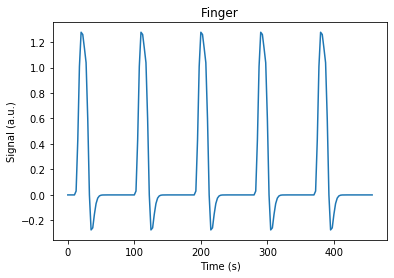

In [146]:
fig, ax = plt.subplots()
ax.plot(design['Finger'])
ax.set(title='Finger', xlabel='Time (s)', ylabel='Signal (a.u.)');

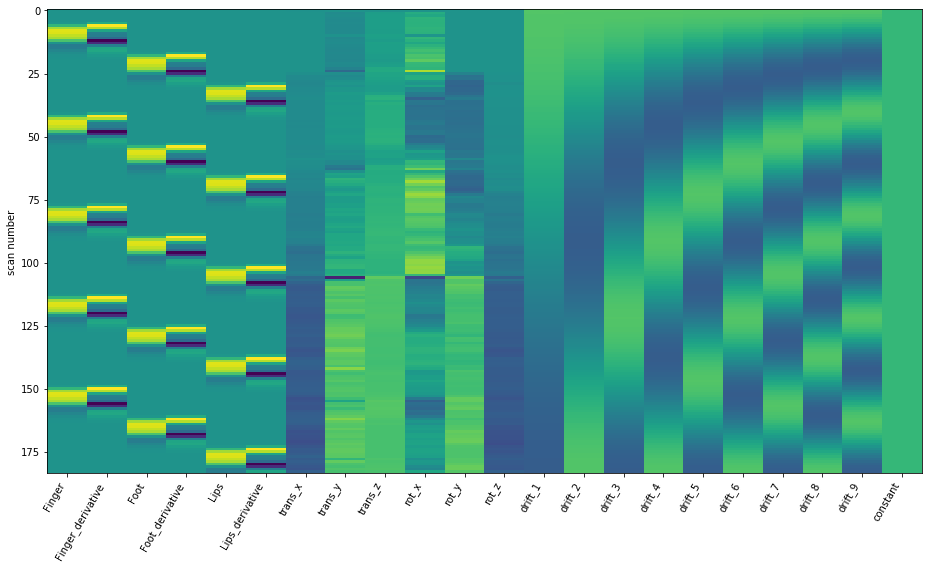

In [147]:
fig, ax = plt.subplots(figsize=(13, 8))
plot_design_matrix(design, ax=ax);

The design matrix accurately reflects what we saw in the events file. But if we look at the actual _experimental design_, we can see that there is an ordering effect (the trial order always goes Finger-Foot-Lips). Generally, you want to avoid this in an actual experiment. 

Remember: The design matrix is what defines our regressors. We are trying to _predict actual brain activity_ using an a model of activity that we would expect to arise from the task. Each condition (AKA trial type) is defined as a single regressor. In our case, we have 3 task regressors of interest: Finger, Foot and Lips. The remaining regressors are there to either improve model fit or regress out noise.

### 1.5 Defining a contrast

In [172]:
beta_map = model.compute_contrast('Foot')

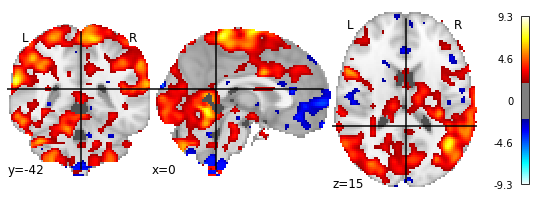

In [173]:
from nilearn.plotting import view_img, plot_stat_map

plot_stat_map(beta_map, threshold=2)

## 2. Putting it all together 



In [160]:
subject_numbers = ['01', '02', '03', '04', '05', '06', 
                   '07', '08', '09', '10']

# events are the same for each subject
event_file = Path('data/task-fingerfootlips_events.tsv')
events = pd.read_table(event_file)

columns = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']

glms = []
for subject in subject_numbers:
    
    # functional image
    func_file = Path(f'data/derivatives/fmriprep/sub-{subject}/ses-test/func/'
                     f'sub-{subject}_ses-test_task-fingerfootlips_space-'
                     'MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
    func_img = nib.load(func_file)

    
    # motion parameters
    conf_file = Path(f'data/derivatives/fmriprep/sub-{subject}/ses-test/func/'
                     f'sub-{subject}_ses-test_task-fingerfootlips_desc-'
                     'confounds_regressors.tsv')
    conf_df = pd.read_table(conf_file)    
    motion_params = conf_df[columns]
    
    # run model
    model = FirstLevelModel(t_r=2.5, hrf_model='glover + derivative', high_pass=.01, 
                        signal_scaling=False, standardize=True, smoothing_fwhm=6, 
                        mask_img=brain_mask)
    model.fit(func_img, events=events, confounds=motion_params)
    glms.append(model)

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 37 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)
/home/dan/miniconda3/envs/psyc917/lib/python3.7/site-packages/nistats/utils.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')

Computation of 1 runs done in 37 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 37 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 39 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 40 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 40 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 39 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one

We'll save these models to a file to use them for next week when perform a second-level analysis and discuss multiple comparisons. We can save Python objects to disk using the [pickle package](https://docs.python.org/3/library/pickle.html) that comes as part of the Python standard library. A pickle file (`.p`) is Python's equivalent to MATLAB's `.mat` or R's `.Rdata`. Much like how we can pickle a vegetable for long-term storage, we can pickle Python objects :). 

The file we will make will be ~2.5GB because it contains everything belonging to our first-level models. Make sure you have the space available. In a typical project it makes sense to combine first and second level analysis into the same script so that you're not saving off unnecessary files.

In [177]:
with open('first_level_models.p', 'wb') as f:
    pickle.dump(glms, f)

## Further Reading